##### ARTI 560 - Computer Vision  
## Image Classification using Transfer Learning - Exercise

### Objective

In this exercise, you will:

1. Use **VGG16** (pretrained on ImageNet) and adapt it for **CIFAR-10** classification.  
2. Fine-tune the model (freeze → train head → unfreeze some layers → fine-tune) and evaluate performance.  
3.


In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)


### 1) Load CIFAR-10


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

y_train = y_train.squeeze()
y_test  = y_test.squeeze()

class_names = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_test :", x_test.shape,  "y_test :", y_test.shape)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
x_train: (50000, 32, 32, 3) y_train: (50000,)
x_test : (10000, 32, 32, 3) y_test : (10000,)


### 2) Train/Val Split


In [3]:
val_frac = 0.15
n_train = x_train.shape[0]
n_val = int(n_train * val_frac)

idx = np.random.permutation(n_train)
x_train_shuf = x_train[idx]
y_train_shuf = y_train[idx]

x_val = x_train_shuf[:n_val]
y_val = y_train_shuf[:n_val]
x_tr  = x_train_shuf[n_val:]
y_tr  = y_train_shuf[n_val:]

print("Train:", x_tr.shape, y_tr.shape)
print("Val  :", x_val.shape, y_val.shape)
print("Test :", x_test.shape, y_test.shape)


Train: (42500, 32, 32, 3) (42500,)
Val  : (7500, 32, 32, 3) (7500,)
Test : (10000, 32, 32, 3) (10000,)


In [4]:
IMG_SIZE = 224
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

preprocess = tf.keras.applications.vgg16.preprocess_input

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
], name="data_augmentation")

def make_ds(x, y, training=False):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if training:
        ds = ds.shuffle(10_000, seed=SEED, reshuffle_each_iteration=True)
    def _map(img, label):
        img = tf.cast(img, tf.float32)
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
        if training:
            img = data_augmentation(img, training=True)
        img = preprocess(img)
        return img, label
    ds = ds.map(_map, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(x_tr, y_tr, training=True)
val_ds = make_ds(x_val, y_val, training=False)
test_ds = make_ds(x_test, y_test, training=False)


### 3) Visualize a Batch

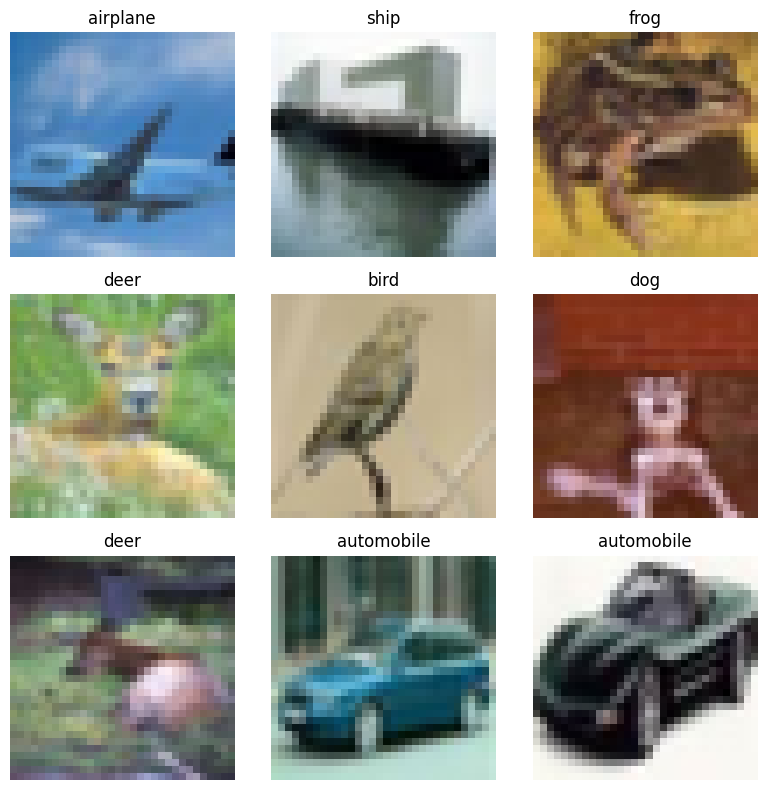

In [5]:
plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_tr[i])
    plt.title(class_names[y_tr[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()


### 4) VGG16


In [6]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs, name="vgg16_cifar10_transfer")
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16_cifar10_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 5,130 (20.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### 5) Train (without finetuning)


In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=3, restore_best_weights=True
    )
]

history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=callbacks
)


Epoch 1/3
665/665 ━━━━━━━━━━━━━━━━━━━━ 98s 134ms/step - accuracy: 0.4681 - loss: 2.3032 - val_accuracy: 0.7984 - val_loss: 0.5934
Epoch 2/3
665/665 ━━━━━━━━━━━━━━━━━━━━ 82s 123ms/step - accuracy: 0.7410 - loss: 0.7778 - val_accuracy: 0.8291 - val_loss: 0.4935
Epoch 3/3
665/665 ━━━━━━━━━━━━━━━━━━━━ 82s 123ms/step - accuracy: 0.7647 - loss: 0.6958 - val_accuracy: 0.8293 - val_loss: 0.4832


### 6) Fine-tune


In [8]:
base_model.trainable = True

fine_tune_at = "block5_conv1"
set_trainable = False
for layer in base_model.layers:
    if layer.name == fine_tune_at:
        set_trainable = True
    layer.trainable = set_trainable

print("Trainable layers in base_model:", sum(l.trainable for l in base_model.layers), "/", len(base_model.layers))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

callbacks_ft = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=3, restore_best_weights=True
    )
]

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=callbacks_ft
)


Trainable layers in base_model: 4 / 19
Epoch 1/3
665/665 ━━━━━━━━━━━━━━━━━━━━ 94s 134ms/step - accuracy: 0.8006 - loss: 0.5831 - val_accuracy: 0.8781 - val_loss: 0.3533
Epoch 2/3
665/665 ━━━━━━━━━━━━━━━━━━━━ 85s 128ms/step - accuracy: 0.8515 - loss: 0.4293 - val_accuracy: 0.8920 - val_loss: 0.3129
Epoch 3/3
665/665 ━━━━━━━━━━━━━━━━━━━━ 85s 128ms/step - accuracy: 0.8703 - loss: 0.3748 - val_accuracy: 0.9011 - val_loss: 0.2903


### 7) Evaluation


In [9]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")


Test loss: 0.3097
Test accuracy: 0.8968


### 8) Plot Training Curves


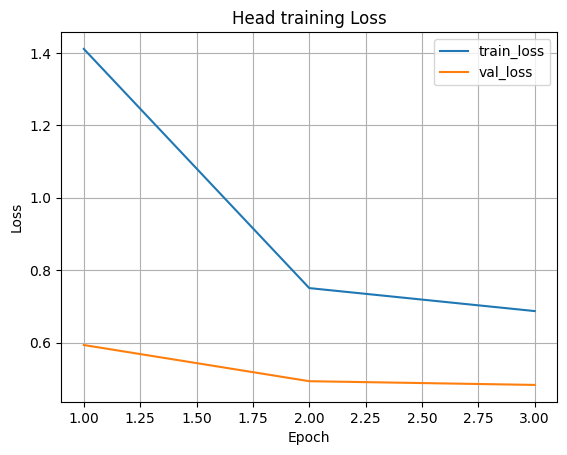

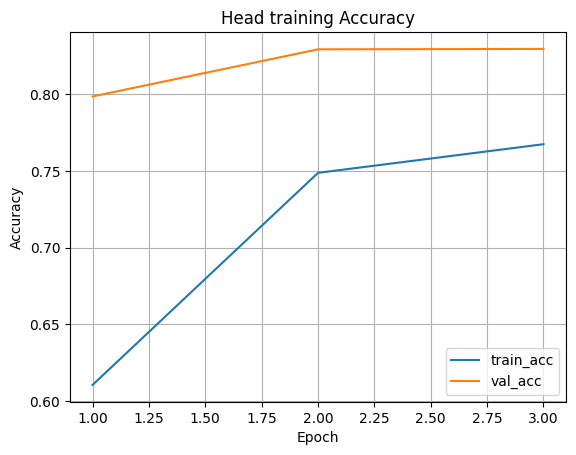

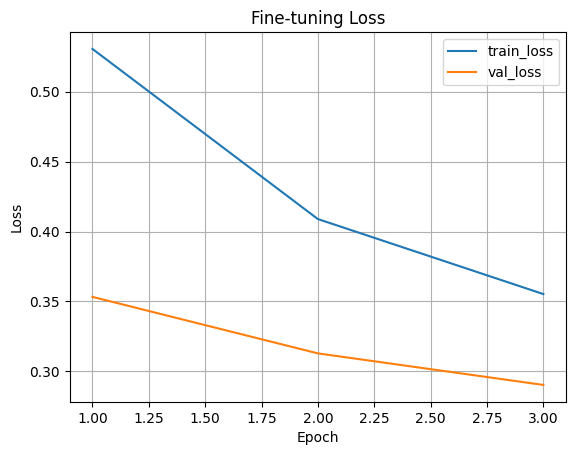

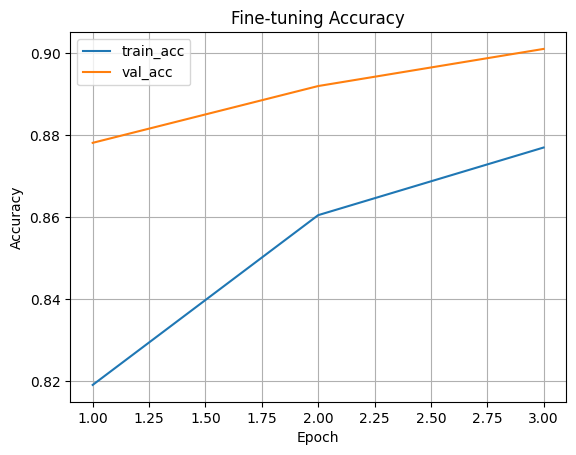

In [10]:
def plot_history(h, title_prefix=""):
    acc = h.history.get("accuracy", [])
    val_acc = h.history.get("val_accuracy", [])
    loss = h.history.get("loss", [])
    val_loss = h.history.get("val_loss", [])

    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, acc, label="train_acc")
    plt.plot(epochs, val_acc, label="val_acc")
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_history(history_head, "Head training")
plot_history(history_ft, "Fine-tuning")


### Questions

* Which model achieved the highest accuracy?

ResNet achieved the highest accuracy. ResNet final validation accuracy achieved around 91.84%, while VGG final validation accuracy achieved approximately 90.11%. It is clear that the ResNet model outperformed the VGG model, precisely by about 1.7% on validation accuracy.

* Which model trained faster?

VGG trained faster. Per epoch time, ResNet: took around 210 seconds per epoch, while VGG took around 90 seconds per epoch. VGG trained in less than half the time per epoch compared to ResNet.

* How might the architecture explain the differences?

ResNet uses residual connections, which help gradients flow more effectively through deep networks, reduce the vanishing gradient problems, and allow training of much deeper models. Furthermore, it had 30 trainable layers out of 190, meaning more trainable capacity than VGG. This deeper architecture generally captures more complex feature representations. VGG has a simpler, sequential architecture, where only 4 trainable layers out of 19 were unfrozen.In addition, it is computationally lighter compared to a deep residual network like ResNet.
